[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/066_ssl/ssl.ipynb)

# Aprendizaje Auto-Supervisado

Hasta ahora hemos visto un montón de ejemplos y aplicaciones de redes neuronales, y en todas ellas hemos utilizado el mismo algoritmo de aprendizaje: el aprendizaje supervisado. Este tipo de aprendizaje se caracteriza por el acceso a un conjunto de datos etiquetado, consistente en pares de ejemplos de entradas y salidas. Un ejemplo muy sencillo de entender es el entrenamiento de un clasificador de imágenes, por ejemplo usando el dataset MNIST, que está compuesto por un conjunto de imágenes y cada una de ellas viene acompañada por su correspondiente etiqueta. Esto nos permite comparar para cada imagen del dataset la salida de nuestra red con la etiqueta real, el *ground truth*, y ajustar los parámetros internos del modelo de manera iterativa para que, poco a poco, las salidas sean lo más parecidas a las etiquetas.

Si bien este proceso es muy utilizado y ha dado muy buenos resultados en muchas aplicaciones, existen muchas otras en las que tales datasets etiquetados simplemente no existen o son escasos debido al coste y la complejidad de elaborarlos. Un ejemplo es el entrenamiento de redes neuronales para tareas de visión artificial en imágenes de satélite. Si queremos, por ejemplo, un detector de coches para calcular la ocupación de aparcamientos necesitaremos, primero, comprar imágenes de alta resolución (que pueden llegar a costar varios miles de euros cada una) y, segundo, etiquetar todos los coches que encontremos en las imágenes (lo cual puede llevar un buen rato). Es en este punto en el que nos preguntamos: ¿es posible entrenar redes neuronales sin etiquetas, solo a partir de datos? A este campo se le conoce como aprendizaje no supervisado, *unsupervised learning* en inglés, y es lo que vamos a explorar en este y los siguientes posts.

## La analogía del pastel de *Yan Lecun*

Uno de los investigadores más influyentes en el ámbito del aprendizaje no supervisado, y del mundo del aprendizaje profundo en general, es Yann Lecun. Para entender la potencia de esta forma de aprendizaje presentó una analogía en la que, si el aprendizaje fuese un pastel, el aprendizaje supervisado solo correspondería al recubrimiento, mientras que el aprendizaje no supervisado sería el interior (y el aprendizaje por refuerzo, la cereza de arriba 😝)

![](https://miro.medium.com/max/4416/1*bvMhd_xpVxfJYoKXYp5hug.png)

Esto nos da una idea de la importancia de ser capaces de entrenar nuestros modelos sin necesidad de un dataset etiquetado. Poder llevar a cabo este mecanismo de manera efectiva abriría la puerta a muchas aplicaciones hoy en día inconcebibles.

Si bien en el campo del *machine learning* existen diferentes algoritmos no supervisados, como algoritmos de clustering (K-Means, DBSCAN, ...), estimación de probabilidad (Gaussian Mixtures) o reducción de dimensionalidad (PCA y otros), los algoritmos no supervisados para *deep learning* son a día de hoy un tema de investigación muy activa, siendo los algoritmos de aprendizaje auto-supervisado (*self-supervised learning*) los más comunes por sus buenos resultados.


## Aprendizaje Auto-Supervisado

El aprendizaje auto-supervisado consiste en el entrenamiento de modelos que aprenden representaciones invariantes a distorsiones de la misma entrada. Esto significa que si un modelo es alimentado por una imagen en color y la misma imagen en blanco y negro, la representación interna (las *features* que nos daría el modelo justo antes del clasificador) debería ser igual, o lo más parecida posible. Diferentes métodos se basan en esta idea para construir, de una manera u otra, una función de pérdida que compare estas representaciones y minimize la diferencia entre pares de transformaciones que provengan de la misma imagen, mientras que maximice la diferencia entre imágenes diferentes. Algunos de los métodos más conocidos son:

- Moco
- SwAV
- SimCLR

En este post vamos a ver un ejemplo utilizando un método simple y reciente (a la hora de elaborar este post): [Barlow Twins](https://arxiv.org/abs/2103.03230). Pero antes, vamos a demostrar la necesidad de esta técnica.

## CIFAR10

Vamos a entrenar una red neuronal convolucional sencilla para la clasificación de imágenes con el dataset [CIFAR10](https://arxiv.org/abs/2103.03230).

hacerlo con pytorch a pelo

In [15]:
import torch
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

In [16]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

ds['train'].imgs.shape, ds['test'].imgs.shape, 

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [17]:
batch_size = 32

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False)
} 

In [18]:
imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

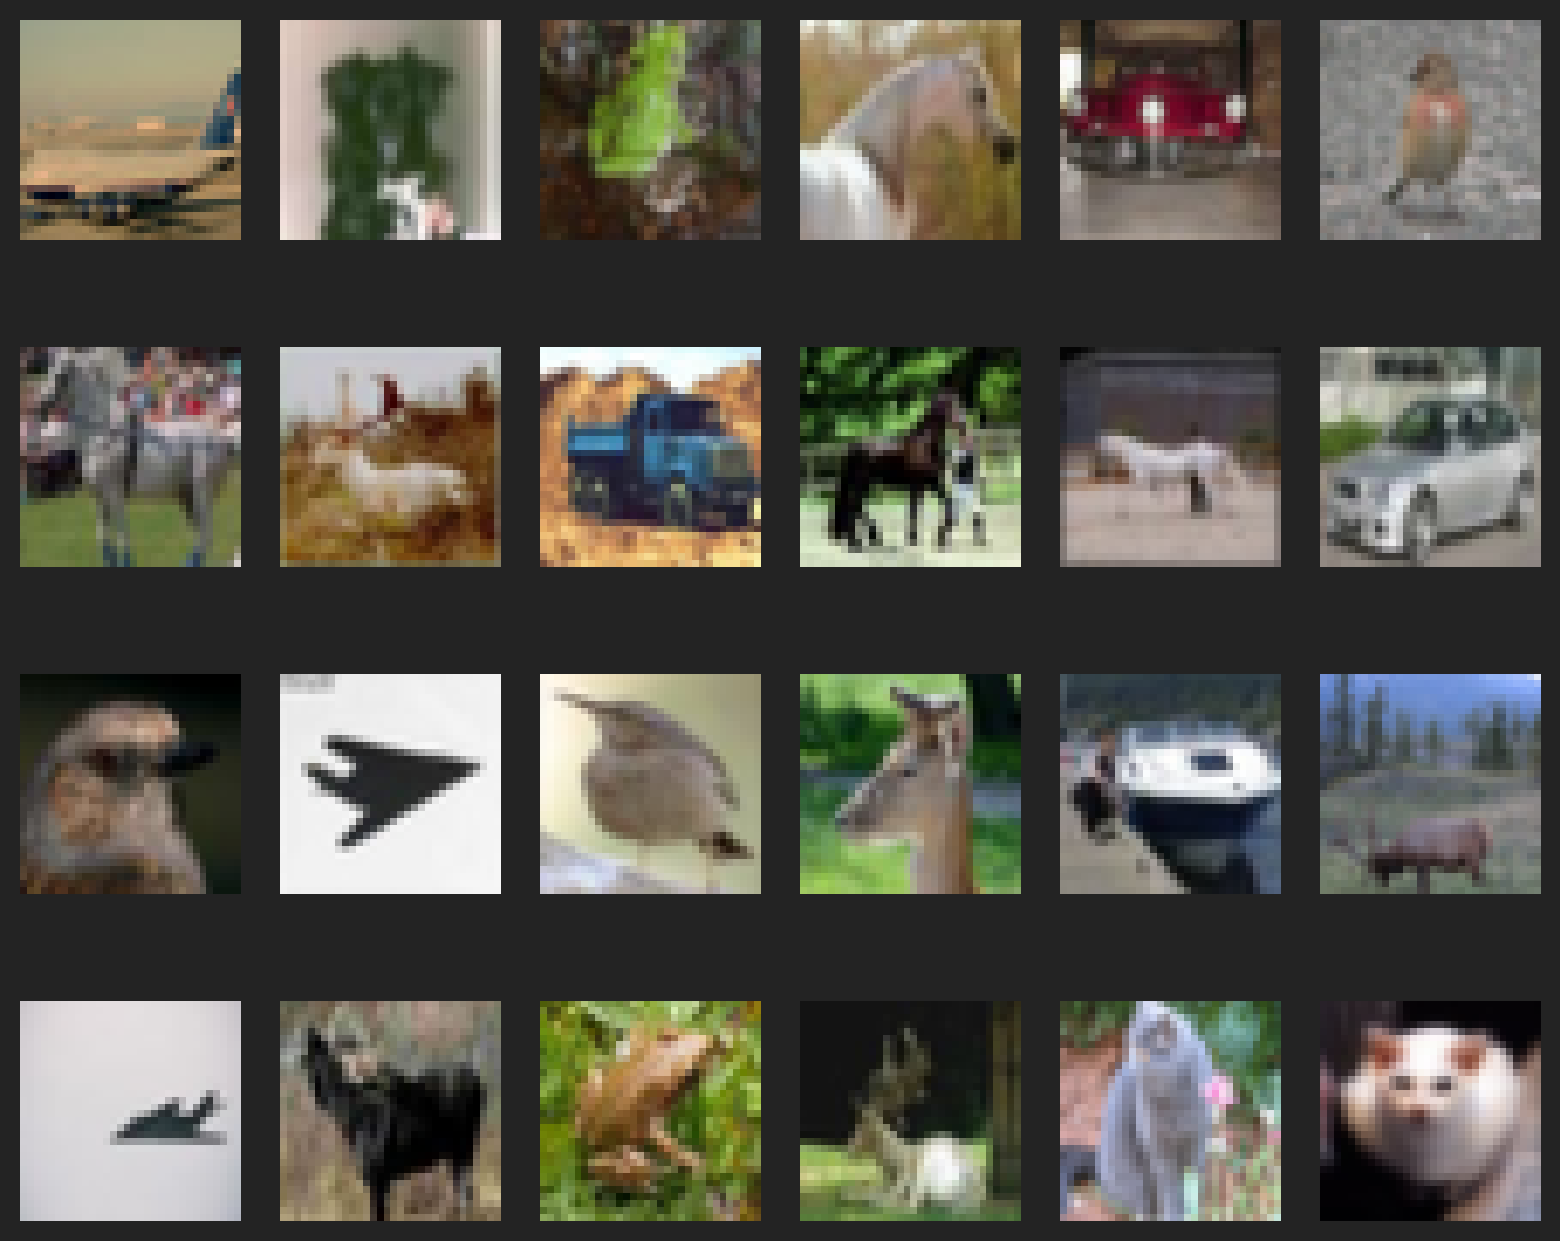

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1,2,0))
        ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
import torch.nn.functional as F

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

class Model(torch.nn.Module):

    def __init__(self, n_channels=3, n_outputs=10):
        super().__init__()
        self.backbone = torch.nn.Sequential(
            block(n_channels, 64),
            block(64, 128),
            block(128, 256)
        )
        self.fc = torch.nn.Linear(256*4*4, n_outputs)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [21]:
model = Model()
output = model(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 10])

In [22]:
from tqdm import tqdm 

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda"):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

In [23]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

hist = train(model, dl, optimizer, epochs=3)

training... loss 1.1332 acc 0.6104:   1%|▍                                               | 16/1563 [00:00<00:09, 158.42it/s]

Epoch 1/3 loss 1.4579 acc 0.4776 test_loss 1.2094 test_acc 0.5742


training... loss 0.9433 acc 0.6647:   1%|▍                                               | 14/1563 [00:00<00:11, 138.61it/s]

Epoch 2/3 loss 1.0557 acc 0.6317 test_loss 1.0397 test_acc 0.6322


testing... loss 0.8620 acc 0.6980: 100%|█████████████████████████████████████████████████| 313/313 [00:00<00:00, 314.26it/s]

Epoch 3/3 loss 0.8906 acc 0.6910 test_loss 0.8620 test_acc 0.6980


In [25]:
import pandas as pd

def plot_hist(hist):
    fig = plt.figure(figsize=(10, 3), dpi=100)
    df = pd.DataFrame(hist)
    ax = plt.subplot(1, 2, 1)
    df[['loss', 'test_loss']].plot(ax=ax)
    ax.grid(True)
    ax = plt.subplot(1, 2, 2)
    df[['acc', 'test_acc']].plot(ax=ax)
    ax.grid(True)
    plt.show()

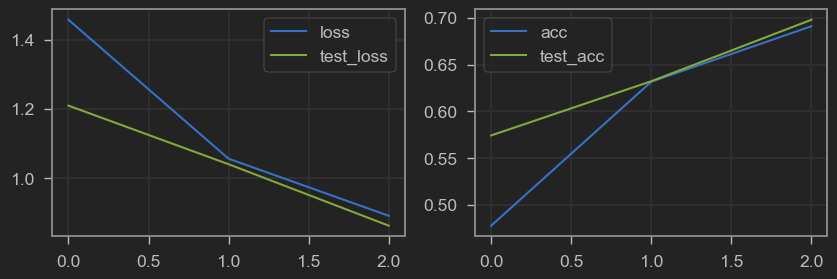

In [26]:
plot_hist(hist)

Llegamos al 70%, podemos hacerlo mejor ? Hemos entrenado from scratch, sabemos que el transfer learnig funciona mejor. Podríamos usar imagenet, pero las imágenes son muy diferentes. Podemos pre-entrenar la red ?

Que pasa si entrenamos con el 1% o 10% de las etiquetas ?

In [27]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, pctg=1.):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
        if pctg < 1.:
            unique_labels = list(range(len(self.classes)))
            filtered_imgs, filtered_labels = [], []
            for lab in unique_labels:
                ixs = (self.labels == lab)
                lim = int(ixs.sum()*pctg)
                filtered_imgs += self.imgs[ixs][:lim].tolist()
                filtered_labels += self.labels[ixs][:lim].tolist()
            self.imgs, self.labels = np.array(filtered_imgs), np.array(filtered_labels)        
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()

In [28]:
ds = {
    'train': Dataset(pctg=0.01),
    'test': Dataset(train=False)
}

Files already downloaded and verified
Files already downloaded and verified


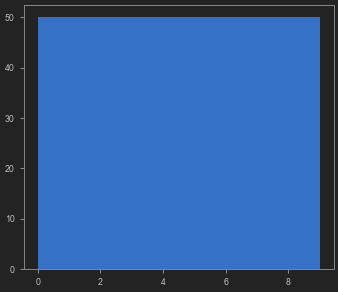

In [32]:
fig, ax = plt.subplots(dpi=50)
ax.hist(ds['train'].labels, bins=10)
plt.show()

In [33]:
pctgs = [0.01, 0.1, 1.]
batch_size = 32
epochs=3
lr=3e-4
hists = []
for pctg in pctgs:
    ds = {
        'train': Dataset(pctg=pctg),
        'test': Dataset(train=False)
    }
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False)
    } 
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = train(model, dl, optimizer, epochs=epochs)
    hists.append(hist)

Files already downloaded and verified
Files already downloaded and verified


testing... loss 2.2132 acc 0.1931:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Epoch 1/3 loss 2.3041 acc 0.0891 test_loss 2.2838 test_acc 0.1894


testing... loss 2.0645 acc 0.2778:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Epoch 2/3 loss 2.2551 acc 0.1914 test_loss 2.2152 test_acc 0.1936


testing... loss 2.0713 acc 0.2618: 100%|█████████████████████████████████████████████████| 313/313 [00:00<00:00, 315.52it/s]


Epoch 3/3 loss 2.1198 acc 0.2629 test_loss 2.0713 test_acc 0.2618
Files already downloaded and verified
Files already downloaded and verified


training... loss 1.8065 acc 0.3508:  11%|█████▌                                           | 18/157 [00:00<00:00, 171.43it/s]

Epoch 1/3 loss 2.0613 acc 0.2347 test_loss 1.8061 test_acc 0.3428


training... loss 1.5512 acc 0.4413:  12%|█████▉                                           | 19/157 [00:00<00:00, 180.96it/s]

Epoch 2/3 loss 1.7256 acc 0.3818 test_loss 1.7108 test_acc 0.3984


testing... loss 1.5699 acc 0.4270: 100%|█████████████████████████████████████████████████| 313/313 [00:01<00:00, 307.47it/s]


Epoch 3/3 loss 1.5713 acc 0.4397 test_loss 1.5699 test_acc 0.4270
Files already downloaded and verified
Files already downloaded and verified


training... loss 1.1761 acc 0.5862:   1%|▍                                               | 16/1563 [00:00<00:09, 158.42it/s]

Epoch 1/3 loss 1.4594 acc 0.4760 test_loss 1.1860 test_acc 0.5752


training... loss 0.9277 acc 0.6835:   1%|▌                                               | 17/1563 [00:00<00:09, 161.91it/s]

Epoch 2/3 loss 1.0697 acc 0.6239 test_loss 0.9859 test_acc 0.6579


testing... loss 0.8612 acc 0.7030: 100%|█████████████████████████████████████████████████| 313/313 [00:00<00:00, 321.01it/s]

Epoch 3/3 loss 0.9090 acc 0.6839 test_loss 0.8612 test_acc 0.7030


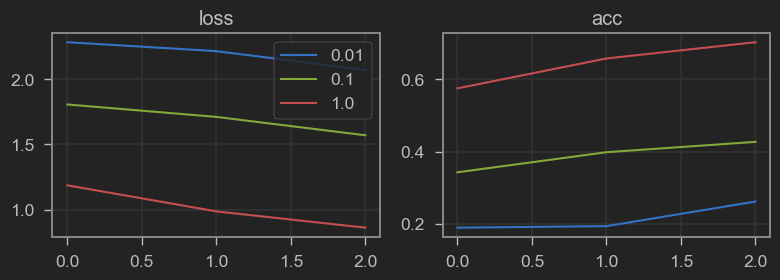

In [39]:
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_loss'])
ax.grid(True)
ax.legend(pctgs)
ax.set_title('loss')
ax = plt.subplot(1, 2, 2)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_acc'])
ax.grid(True)
ax.set_title('acc')
plt.tight_layout()
plt.show()

In [40]:
import torch
import torchvision

class SSLDataset(torch.utils.data.Dataset):
    def __init__(self, trans):
        self.trans = trans
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        self.imgs = np.array([np.array(i[0]) for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        img1 = self.trans(image=img)['image']
        img2 = self.trans(image=img)['image']
        return torch.from_numpy(img1 / 255.).permute(2,0,1).float(), torch.from_numpy(img2 / 255.).permute(2,0,1).float()

In [41]:
import albumentations as A

trans = A.Compose([
    A.RandomResizedCrop(32, 32),
    A.HorizontalFlip(),
    A.ColorJitter(),
    A.ToGray(),
    A.GaussianBlur(),
    A.Solarize()
])

ds = SSLDataset(trans)

Files already downloaded and verified


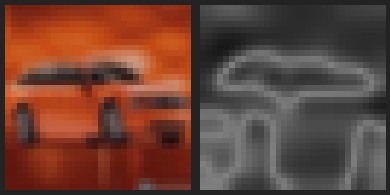

In [98]:
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(ds))
img1, img2 = ds[ix]
fig = plt.figure(dpi=50)
ax = plt.subplot(1, 2, 1)
ax.imshow(img1.permute(1,2,0))
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(img2.permute(1,2,0))
ax.axis('off')
plt.tight_layout()
plt.show()

In [99]:
class SSLModel(torch.nn.Module):

    def __init__(self, n_channels=3, n_outputs=10):
        super().__init__()
        self.backbone = torch.nn.Sequential(
            block(n_channels, 64),
            block(64, 128),
            block(128, 256)
        )
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(256*4*4, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.shape[0], -1)
        x = self.mlp(x)
        return x

In [100]:
SSLmodel = SSLModel()
output = SSLmodel(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 1024])

In [101]:
from tqdm import tqdm 

def SSLstep(model, batch, device, l=5e-3):
    # two randomly augmented versions of x
    x1, x2 = batch
    x1, x2 = x1.to(device), x2.to(device)
    
    # compute representations
    z1 = model(x1)
    z2 = model(x1)
    
    # normalize repr. along the batch dimension
    N, D = z1.shape
    z1_norm = (z1 - z1.mean(0)) / z1.std(0) # NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD
    
    # cross-correlation matrix
    c = (z1_norm.T @ z2_norm) / N # DxD
    
    # loss
    c_diff = (c - torch.eye(D, device=device)).pow(2) # DxD
    # multiply off-diagonal elems of c_diff by lambda
    d = torch.eye(D, dtype=bool)
    c_diff[~d] *= l
    return c_diff.sum()

def SSLtrain(model, dl, optimizer, scheduler, epochs=10, device="cuda"):
    model.to(device)
    hist = {'loss': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl)
        for batch in bar:
            optimizer.zero_grad()
            loss = SSLstep(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            bar.set_description(f"training... loss {np.mean(l):.4f}")
        hist['loss'].append(np.mean(l))
        scheduler.step()
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

In [102]:
dl = torch.utils.data.DataLoader(ds, batch_size=2048, shuffle=True)
SSLmodel = SSLModel()
optimizer = torch.optim.Adam(SSLmodel.parameters(), lr=0.002)
epochs = 100
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.1, max_lr=0.2, total_steps=epochs, verbose=True)
hist = SSLtrain(SSLmodel, dl, optimizer, scheduler, epochs=epochs)

  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3790e-02.
Epoch 1/100 loss 1962.4831


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0460e-02.
Epoch 2/100 loss 1506.9657


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6000e-02.
Epoch 3/100 loss 1026.5005


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.7330e-02.
Epoch 4/100 loss 811.6546


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2067e-01.
Epoch 5/100 loss 657.2221


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5200e-01.
Epoch 6/100 loss 509.1999


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7754e-01.
Epoch 7/100 loss 413.7958


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9421e-01.
Epoch 8/100 loss 306.8487


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 9/100 loss 246.1601


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9994e-01.
Epoch 10/100 loss 197.7408


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9976e-01.
Epoch 11/100 loss 154.8064


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9945e-01.
Epoch 12/100 loss 125.1655


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9903e-01.
Epoch 13/100 loss 103.6689


  0%|                                                                                                | 0/25 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9848e-01.
Epoch 14/100 loss 88.6962


training... loss 81.8823:  12%|███████▍                                                      | 3/25 [00:06<00:44,  2.02s/it]


KeyboardInterrupt: 

In [ ]:
torch.jit.script(SSLmodel.backbone.cpu()).save('SSLbackbone.pt')

In [ ]:
class FTModel(torch.nn.Module):

    def __init__(self, backbone='SSLbackbone.pt', n_channels=3, n_outputs=10):
        super().__init__()
        self.backbone = torch.jit.load(backbone)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.fc = torch.nn.Linear(256*4*4, n_outputs)

    def forward(self, x):
        with torch.no_grad():
            x = self.backbone(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
FTmodel = FTModel()
output = FTmodel(torch.randn(32, 3, 32, 32))

output.shape

In [ ]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

batch_size = 32
dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False)
} 

FTmodel = FTModel()
optimizer = torch.optim.Adam(FTmodel.parameters(), lr=3e-4)

hist = train(model, dl, optimizer, epochs=3)

In [ ]:
pctgs = [0.01, 0.1, 1.]
batch_size = 32
epochs=3
lr=3e-4
ssl_hists = []
for pctg in pctgs:
    ds = {
        'train': Dataset(pctg=pctg),
        'test': Dataset(train=False)
    }
    dl = {
        'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
        'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False)
    } 
    FTmodel = FTModel()
    optimizer = torch.optim.Adam(FTmodel.parameters(), lr=lr)
    hist = train(FTmodel, dl, optimizer, epochs=epochs)
    ssl_hists.append(hist)

In [ ]:
fig = plt.figure(figsize=(8, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_loss'])
    ax.plot(ssl_hists[i]['ssl_test_loss'])
ax.grid(True)
ax.legend(pctgs)
ax.set_title('loss')
ax = plt.subplot(1, 2, 2)
for i, pctg in enumerate(pctgs):
    ax.plot(hists[i]['test_acc'])
    ax.plot(ssl_hists[i]['ssl_test_acc'])
ax.grid(True)
ax.set_title('acc')
plt.tight_layout()
plt.show()